

---

# Import libraries

In [55]:
import numpy as np
import pandas as pd 

#visualization 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

#preprocessing 
import sklearn 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_roc_curve

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

# Download datasets

In [56]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

**Описание данных**:

***events_data*** - данные о действиях, которые совершают студенты на уроках (стэпах): 


*   *step_id* - id урока (стэпа);
*   *user_id* - анонимизированный id юзера;
*   *timestamp* - время наступления события в формате unix date;
*   *action* - события, возможные значения (discovered: переход на стэп; viewed: просмотр стэпа; started_attempt: начал решать; passed: сдал).

***submissions_data*** - данные о времени и статусах сабмитов к практическим заданиям:


*   *step_id* - id стэпа;
*   *timestamp* - время отправки решения в формате unix date;
*   *submission_status* - статус решения;
*   *user_id* - анонимизированный id юзера.



# Set the parameters

In [57]:
random_state = 0 

metrics_all = {1:'accurancy', 2:'precision', 3:'recall', 4:'f1', 5:'rocauc_score'}

latest_date_of_data = max(events_data.timestamp.max(), submissions_data.timestamp.max())
passed_course_score = 40 #int(76*0.9)
seconds_in_day = 24*60*60

In [58]:
cv_n_split = 3
test_split_size = 0.15
metrics_now = [1, 2, 3, 5]

In [59]:
drop_out_threshold = 20 * seconds_in_day
learning_time_threshold = 3 * seconds_in_day

# Feature engineering & Exploratory data analysis

In [60]:
#разбираемся с датами
def add_date(df):
  '''
  переводит timestamp в формат datetime и перзаписывает в новую колонку, 
  добавляет колонку с датой
  '''
  df['date'] = pd.to_datetime(df.timestamp, unit='s')
  df['day'] = df.date.dt.date

add_date(events_data)
add_date(submissions_data)

95% of the data lower than 59.760440972222156
90% of the data lower than 18.325995370370403


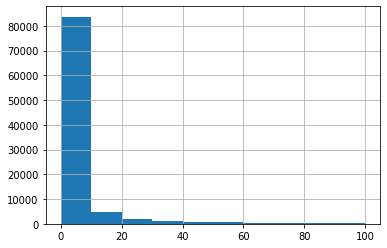

In [61]:
#определяем количество дней после которого можно считать что пользователь дропнулся 
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id').timestamp.apply(np.array)\
    .apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis=0) / (24*60*60))
gap_data[gap_data<100].hist()
print('95% of the data lower than', gap_data.quantile(0.95))
print('90% of the data lower than', gap_data.quantile(0.9))

In [62]:
#создадим датафрейм с данными, необходимыми для определения целевой переменной и тренировочной выборки 
#человек прошел курс если правильно ответил на 90% степов с вопросами - 68 (76*0,9); дропнулся если после последнего посещения курса прошло более 20 дней.
#в остальных случаях человек считается проходящим курс без определенного статуса
#обучения проводим на пользователях, которые либо ушли, либо уже прошли курс

data_to_targetvariable = submissions_data.drop_duplicates(subset=['user_id', 'step_id', 'submission_status'])\
        .pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0)\
        .reset_index()[['user_id', 'correct']]

data_to_targetvariable = data_to_targetvariable.merge(
    events_data.groupby('user_id', as_index=False).timestamp.max(),
    on='user_id', how='right').fillna(0).rename({'timestamp':'last_timestamp'}, axis=1)

data_to_targetvariable['is_gone_user'] = (latest_date_of_data - data_to_targetvariable.last_timestamp) > drop_out_threshold
data_to_targetvariable['passed_course'] = data_to_targetvariable.correct >= passed_course_score

data_to_targetvariable.head()

,user_id,correct,last_timestamp,is_gone_user,passed_course
0,1,0.0,1472827464,True,False
1,2,2.0,1519226966,True,False
2,3,29.0,1444581588,True,False
3,5,2.0,1499859939,True,False
4,7,0.0,1521634660,True,False


In [63]:
#чтобы делать выводы на основе первых трех дней, который юзер проводит на платформе, нужно отобрать только те действия, 
#которые юзер совершил в первые три дня
#сначала создаем табличку где собираем данные о дате первой сессии и считаем три дня от нее

user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp':'min'}).rename({'timestamp':'min_timestamp'}, axis=1)
user_min_time['user_learning_time_threshold'] = user_min_time.user_id.map(str) + '_' + \
                                                (user_min_time.min_timestamp + learning_time_threshold).map(str)

user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [64]:
def select_kdays_data(df):
  '''
  отбирает данные первых k дней для каждого юзера
  '''
  df['user_time'] = df.user_id.map(str) + '_' + df.timestamp.map(str)
  df = df.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
  data_train = df[df.user_time <= df.user_learning_time_threshold]
  if data_train.groupby('user_id').day.nunique().max() != (learning_time_threshold / seconds_in_day + 1):
    print('Something went wrong')
  return df, data_train 

events_data, events_data_train = select_kdays_data(events_data)
submissions_data, submissions_data_train = select_kdays_data(submissions_data)

In [65]:
#нужно посчитать сколько раз пользователь неправильно проходил последний шаг и прошел ли он его
last_step_data = submissions_data_train.groupby('user_id').step_id.max().reset_index()
submissions_data_train['users_step'] = submissions_data_train.user_id.map(str) + '_' + submissions_data_train.step_id.map(str)
last_step_data['users_laststep'] = last_step_data.user_id.map(str) + '_' + last_step_data.step_id.map(str)
last_step_data = submissions_data_train.merge(last_step_data[['user_id', 'users_laststep']], on='user_id', how='outer')\
                                                     [['step_id', 'user_id', 'submission_status', 'users_step', 'users_laststep']]
last_step_data = last_step_data[last_step_data.users_step == last_step_data.users_laststep]
last_step_data = last_step_data.pivot_table(index='user_id', columns='submission_status', 
                                                aggfunc='count', values='step_id', fill_value=0).reset_index()\
                                                .rename({'wrong':'wrongtried_laststep'}, axis=1)
last_step_data['passed_laststep'] = np.where(np.array(last_step_data.correct)>0, 1, 0)
last_step_data = last_step_data.drop('correct', axis=1)
last_step_data.head()

submission_status,user_id,wrongtried_laststep,passed_laststep
0,2,0,1
1,3,0,1
2,8,0,1
3,14,1,0
4,16,0,1


In [89]:
  #собираем данные, необходимые для обучения модели: количество активных дней из трех доступных, количество пройденых степов
  #количество правильных и неправильных ответов, их соотношение и количество просмотренных степов
  
  X = submissions_data_train.groupby('user_id', as_index=False).day.nunique().rename({'day':'days'}, axis=1)
  steps_tried = submissions_data_train.groupby('user_id', as_index=False).step_id.nunique().rename(columns={'step_id':'steps_tried'})
  X = X.merge(steps_tried, on='user_id', how='outer')
  X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                                     columns='submission_status', 
                                     values='step_id',
                                     aggfunc='count',
                                     fill_value=0).reset_index())
  X['correct_ratio'] = X.correct / (X.correct + X.wrong)
  X = X.merge(events_data_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0)\
                              .reset_index()[['user_id', 'viewed']])
  X = X.merge(data_to_targetvariable[['user_id', 'passed_course', 'is_gone_user']], how='outer').fillna(0)
  X = X.merge(last_step_data, on='user_id', how='outer').fillna(0)

In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19234 entries, 0 to 19233
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              19234 non-null  int64  
 1   days                 19234 non-null  float64
 2   steps_tried          19234 non-null  float64
 3   correct              19234 non-null  float64
 4   wrong                19234 non-null  float64
 5   correct_ratio        19234 non-null  float64
 6   viewed               19234 non-null  float64
 7   passed_course        19234 non-null  bool   
 8   is_gone_user         19234 non-null  bool   
 9   wrongtried_laststep  19234 non-null  float64
 10  passed_laststep      19234 non-null  float64
dtypes: bool(2), float64(8), int64(1)
memory usage: 1.5 MB


In [90]:
#из всех данных нам нужно выбрать пользователей, которые уже либо сдали, либо ушли, остальных откидываем, 
#так как, на данный момент, мы не можем их точно никак класифицировать 

X = X[-((X.passed_course==False)&(X.is_gone_user==False))]
y = X.passed_course
y = pd.Series(np.where(np.array(y)==True, 1, 0))
X = X.drop(['passed_course', 'is_gone_user', 'user_id'], axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
0,1.0,2.0,2.0,0.0,1.00,9.0
1,1.0,4.0,4.0,4.0,0.50,20.0
2,1.0,11.0,9.0,21.0,0.30,154.0
3,1.0,1.0,0.0,1.0,0.00,9.0
4,3.0,23.0,23.0,27.0,0.46,132.0


# Preparing to modeling

In [91]:
#Standartization
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

#Normalization
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

# Synthesis valid as test for selection models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, random_state=random_state)

# Splitting train data for model tuning with cross-validation
cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_split_size, random_state=random_state)

In [96]:
#у нас несбалансированная выборка, дропнувшихся пользователей почти 90%, поэтому увеличим количество пользователей, которые сдали курс
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [97]:
acc_all = np.empty((3, len(metrics_now)*2)).tolist()


def acc_metrics_calc(num, model, X_train, X_test, y_train, y_test):
  '''
  Calculation of accuracy of model by different metrics
  '''
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

  global acc_all
  
  num_acc = 0 
  for metric in metrics_now:
    if metric == 1:
      #accuracy_score
      acc_train = round(accuracy_score(y_train, train_predict) * 100, 2)
      acc_test = round(accuracy_score(y_test, test_predict) * 100, 2)
    elif metric == 2:
      #precision_score
      acc_train = round(precision_score(y_train, train_predict) * 100, 2)
      acc_test = round(precision_score(y_test, test_predict) * 100, 2)
    elif metric == 3:
      #recall_score 
      acc_train = round(recall_score(y_train, train_predict) * 100, 2)
      acc_test = round(recall_score(y_test, test_predict) * 100, 2)
    elif metric == 4:
      #f1_score
      acc_train = round(f1_score(y_train, train_predict) * 100, 2)
      acc_test = round(f1_score(y_test, test_predict) * 100, 2)
    elif metric == 5:
      #roc_auc_score
      acc_train = round(roc_auc_score(y_train, train_predict) * 100, 2)
      acc_test = round(roc_auc_score(y_test, test_predict) * 100, 2)
    print(metrics_all[metric], 'for train =', acc_train)
    print(metrics_all[metric], 'for test =', acc_test)
    acc_all[num][num_acc] = acc_train #train
    acc_all[num][num_acc+1] = acc_test #test
    num_acc += 2

In [98]:
def plot_learning_curve(estimator, title, X, y, cv=cv_train, train_sizes=np.linspace(.1, 1.0, 5), 
                        random_state=random_state):
    """
    Generate the test and training learning curve.
    
    """
    plt.figure(figsize=(20, 5))

    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_split_size, random_state=random_state)
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator=estimator, X=X, y=y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    plt.show()
    return

# Tuning models and test

In [99]:
%%time
# Random Forest

random_forest = RandomForestClassifier()
param_grid = {'n_estimators': [300, 450, 600], 'min_samples_split': [60], 'min_samples_leaf': [20, 30, 40], 
              'max_features': ['auto'], 'max_depth': [5, 7, 9, 13], 'criterion': ['gini'], 'bootstrap': [False]}
random_forest_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                             cv=cv_train, verbose=False)
random_forest_CV.fit(X_train, y_train)
print('Best parameters for Random Forest:', random_forest_CV.best_params_, '\n')
acc_metrics_calc(1, random_forest_CV, X_train, X_test, y_train, y_test)

Best parameters for Random Forest: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 20, 'min_samples_split': 60, 'n_estimators': 450} 

accurancy for train = 81.11
accurancy for test = 78.26
precision for train = 79.39
precision for test = 29.36
recall for train = 84.04
recall for test = 78.87
rocauc_score for train = 81.11
rocauc_score for test = 78.53
CPU times: user 9min 6s, sys: 410 ms, total: 9min 7s
Wall time: 9min 7s


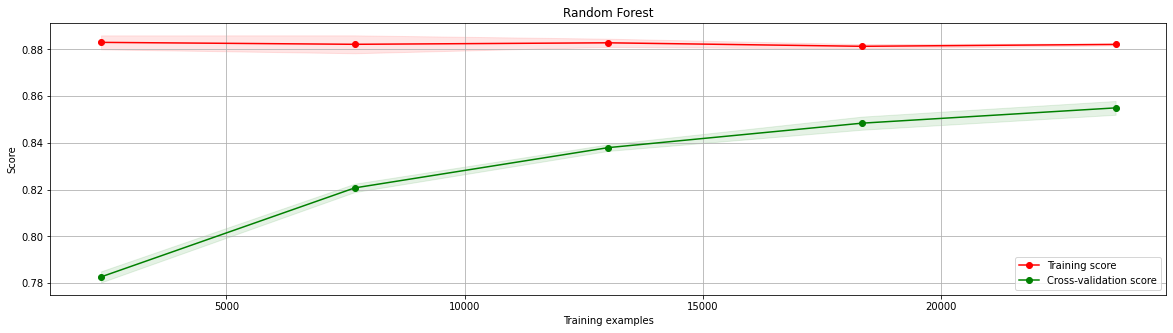

In [75]:
# Building learning curve of model
plot_learning_curve(random_forest, "Random Forest", X_train, y_train)

In [76]:
%%time
# Gradient Boosting Classifier

gradient_boosting = GradientBoostingClassifier()
param_grid = {'learning_rate' : [0.001, 0.01, 0.1],
              'max_depth': [i for i in range(2,5)],
              'min_samples_leaf': [i for i in range(2,5)]}
gradient_boosting_CV = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid, 
                                    cv=cv_train, verbose=False)
gradient_boosting_CV.fit(X_train, y_train)
print("Best parameters for Gradient Boosting Classifier:", gradient_boosting_CV.best_params_, '\n')
acc_metrics_calc(2, gradient_boosting_CV, X_train, X_test, y_train, y_test)

Best parameters for Gradient Boosting Classifier: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2} 

accurancy for train = 80.24
accurancy for test = 76.7
precision for train = 77.92
precision for test = 27.96
recall for train = 84.38
recall for test = 79.93
rocauc_score for train = 80.24
rocauc_score for test = 78.13
CPU times: user 2min 11s, sys: 34.8 ms, total: 2min 11s
Wall time: 2min 11s


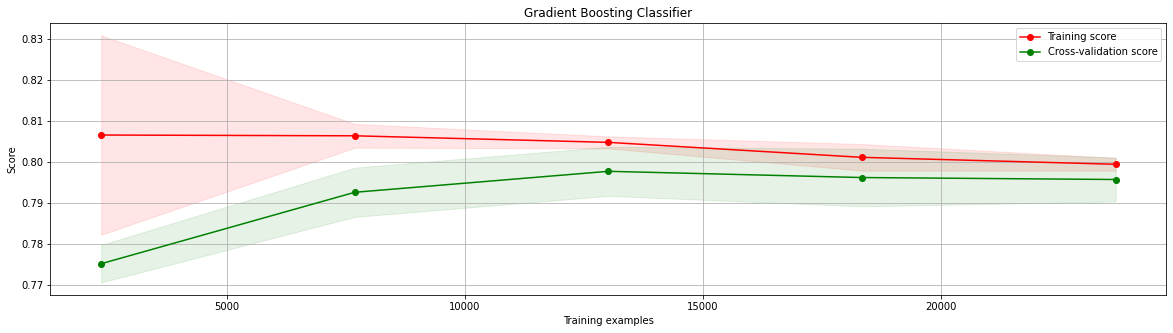

In [77]:
# Building learning curve of model
plot_learning_curve(gradient_boosting_CV, "Gradient Boosting Classifier", X_train, y_train)

In [78]:
%%time
# Logistic Regression

logreg = LogisticRegression()
logreg_CV = GridSearchCV(estimator=logreg, param_grid={'C' : [.1, .3, .5, .7, 1]}, cv=cv_train, verbose=False)
logreg_CV.fit(X_train, y_train)
acc_metrics_calc(0, logreg_CV, X_train, X_test, y_train, y_test)

accurancy for train = 77.54
accurancy for test = 73.39
precision for train = 74.74
precision for test = 25.73
recall for train = 83.22
recall for test = 83.8
rocauc_score for train = 77.54
rocauc_score for test = 78.0
CPU times: user 2.99 s, sys: 2.07 s, total: 5.07 s
Wall time: 2.58 s


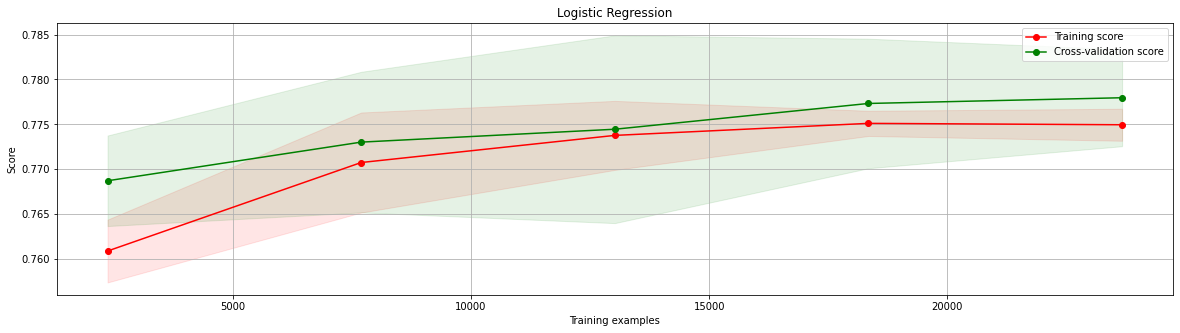

In [79]:
# Building learning curve of model
plot_learning_curve(logreg, "Logistic Regression", X_train, y_train)

# Models comparison

In [80]:
model_data = pd.DataFrame(acc_all, index=['Logistic_Regression', 'Random_Forest', 'Gradient_Boosting_Classifier'], 
             columns=['acc_tran', 'acc_test', 'pre_train', 'pre_train', 
                      'rec_train', 'rec_test', 'rocauc_train', 'rocauc_test'])


model_data.sort_values(ascending=False, by='rocauc_test')

,acc_tran,acc_test,pre_train,pre_train,rec_train,rec_test,rocauc_train,rocauc_test
Random_Forest,80.74,78.37,79.02,29.47,83.69,78.87,80.74,78.59
Gradient_Boosting_Classifier,80.24,76.70,77.92,27.96,84.38,79.93,80.24,78.13
Logistic_Regression,77.54,73.39,74.74,25.73,83.22,83.80,77.54,78.00


In [81]:
logreg_CV.best_estimator_.coef_

array([[ 1.97083009,  3.4096496 ,  4.27186381,  0.06828921,  1.06101858,
        -0.55031435, -0.93094828, -0.01022641]])

In [82]:
gradient_boosting_CV.best_estimator_.feature_importances_

array([3.89702063e-02, 5.78448047e-02, 7.66997340e-01, 1.22256373e-02,
       6.24924305e-02, 5.54830441e-02, 5.35750399e-03, 6.29033151e-04])

In [83]:
random_forest_CV.best_estimator_.feature_importances_

array([0.06883756, 0.22157486, 0.25672978, 0.04059498, 0.09342805,
       0.21178954, 0.00418991, 0.10285532])

In [84]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed,wrongtried_laststep,passed_laststep
0,0.25,0.026316,0.026316,0.000000,1.00,0.011628,0.000000,1.0
1,0.25,0.052632,0.052632,0.009009,0.50,0.025840,0.000000,1.0
2,0.25,0.144737,0.118421,0.047297,0.30,0.198966,0.000000,1.0
3,0.25,0.013158,0.000000,0.002252,0.00,0.011628,0.032258,0.0
4,0.75,0.302632,0.302632,0.060811,0.46,0.170543,0.000000,1.0


**Переменные, которые вносят самый большой вклад в модель:** количество правильно решенных задач, количество просмотренных уроков, количество заданий, которые пользователь попробовал пройти, а также соотношение решенных заданий ко всем. 
Эти фичи могут стать отправной точкой к увеличению процента пользователей, которые проходят курс. 

**Возможные предложения:**
* добавить подсказки к "сложным" заданиям, которые сложнее всего даются пользователям;

* отправлять пуши пользоватлям с необычными посылами, например, его возможными результатами, которые он сможет достичь после прохождение курса. Пример: "Еще немного и ты аналитик. До прохождения курса осталось х заданий".
* провести А/В-тесты для увеличения удержания пользователей на курсе (увеличение количество пройденных уроков). Например, использование элементов геймификации, раздробление уроков на более мелкие части и т.п.
* собрать больше данных о пользователях. Например, количество написанных комментариев и другой активности на курсе, информация о пользователе (образование, место проживание, возраст и т.п.), информация о прохождении других курсов и т.п.